In [44]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

WINDOW = 22

In [70]:
df = pd.read_csv("../data/data_18_07.csv", delimiter=',', index_col=0)
splitFrame = pd.DataFrame(df.date_time.str.split(' ',1).tolist(), columns = ['date','time'],index = df.index)
df = pd.concat([splitFrame, df[df.columns[2:]]], axis=1)
df.head()

,date,time,open,close,low,high,volume,pair_id
#,,,,,,,,
1,2015-08-01,07:00:00.000000,284.000000,279.845023,275.724508,284.000000,301.376392,83
2,2015-08-02,07:00:00.000000,280.000000,286.438075,280.000000,286.438075,106.563859,83
3,2015-08-03,07:00:00.000000,285.438300,288.965644,284.286275,288.965644,75.706794,83
4,2015-08-04,07:00:00.000000,281.104486,288.000000,281.104486,288.000000,11.947218,83
5,2015-08-05,07:00:00.000000,288.200000,287.569800,279.793314,288.965425,9.297527,83


In [71]:
df.tail()

,date,time,open,close,low,high,volume,pair_id
#,,,,,,,,
714,2017-07-14,07:00:00.000000,2327.300000,2205.907300,2134.000000,2350.000000,3.329353e+07,83
715,2017-07-15,07:00:00.000000,2205.907300,1977.500000,1972.000010,2213.872903,5.927525e+07,83
716,2017-07-16,07:00:00.000000,1977.500000,1925.900000,1835.000277,2054.000000,6.640352e+07,83
717,2017-07-17,07:00:00.000000,1922.193300,2223.403082,1922.193300,2224.845000,5.942922e+07,83
718,2017-07-18,07:00:00.000000,2223.403082,2266.100001,2117.270963,2287.608020,2.011914e+07,83


In [85]:
scaler = MinMaxScaler()

all_df = df.copy()

x = all_df['close'].copy()
y = all_df['close'].copy()

x = scaler.fit_transform(x.values.reshape(-1, 1))

y = scaler.fit_transform(y.values.reshape(-1, 1))

In [86]:
def load_data(X, seq_len, train_size=1):
    # Определяем число фич
    amount_of_features = X.shape[1] 
    
    sequence_length = seq_len + 1 
    data = []
    
    # Бьем тренировочные данные на блоки по размеру окна
    for index in range(len(X)+1 - sequence_length):
        data.append(X[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    # Меняем размер входного фрейма на [dim, window, featureNumber]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    return x_train, y_train

X_train, y_train = load_data(x, WINDOW)

print (X_train.shape, y_train.shape)

(696, 22, 1) (696,)


In [87]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [88]:
model = build_model(input_shape=(WINDOW, 1))

In [89]:
print('START FIT MODEL...')
start = time.time()
model.fit(X_train, y_train, batch_size=32, epochs=500,
          verbose=0)
end = time.time()

print ('Learning time: ', end-start)

START FIT MODEL...
Learning time:  404.8493483066559


In [90]:
save_model(model, "../modelOneFeature/model_btc_close_oneFeature5days18_07.h5")

In [78]:
model = load_model("../modelOneFeature/model_btc_close_oneFeature5days18_07.h5")

In [21]:
# Test model - how works train_on_batch
# Тестирование дообучения
"""import time

start = time.time()
print('START FIT MODEL...')
model_min_o = build_model(input_shape=(WINDOW, 1))
model_min_o.fit(X_train[:-1], y_train[:-1], batch_size=32, epochs=500,
          verbose=0)
end = time.time()

print ('Learning time: ', end-start)
model_min_o.train_on_batch(X_train[693].reshape(1,22, 1), y_train[693].reshape(1,))
print (scaler.inverse_transform(model_min_o.predict([x[-WINDOW:].reshape(1,22, 1)])))

print (scaler.inverse_transform(model.predict([x[-WINDOW:].reshape(1,22, 1)])))"""

START FIT MODEL...
Learning time:  402.83589601516724
[[ 2084.13012695]]
[[ 2202.64501953]]


In [91]:
trainPredict = model.predict(X_train)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])

trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 43.17 RMSE


In [92]:
prices = all_df.close.values.astype('float32')
prices = prices.reshape(len(prices), 1)

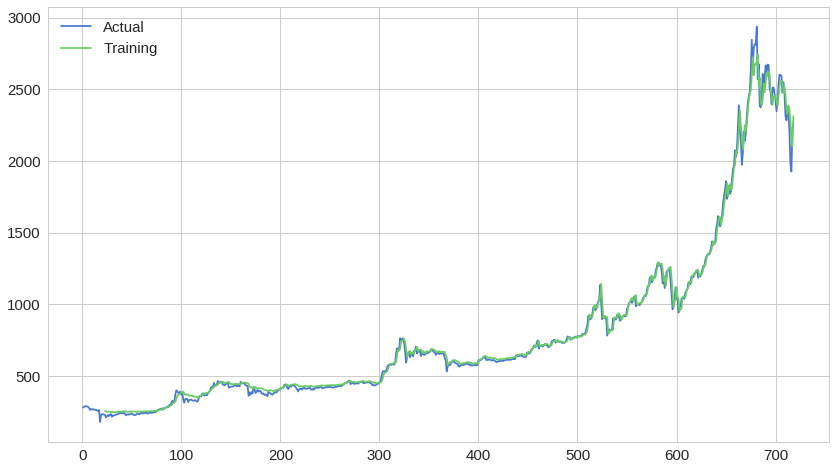

In [93]:
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

plt.plot(pd.DataFrame(prices, columns=["close"], index=all_df.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.index).close, label='Training')
plt.legend(loc='best')
plt.show()


In [94]:
df.tail()

,date,time,open,close,low,high,volume,pair_id
#,,,,,,,,
714,2017-07-14,07:00:00.000000,2327.300000,2205.907300,2134.000000,2350.000000,3.329353e+07,83
715,2017-07-15,07:00:00.000000,2205.907300,1977.500000,1972.000010,2213.872903,5.927525e+07,83
716,2017-07-16,07:00:00.000000,1977.500000,1925.900000,1835.000277,2054.000000,6.640352e+07,83
717,2017-07-17,07:00:00.000000,1922.193300,2223.403082,1922.193300,2224.845000,5.942922e+07,83
718,2017-07-18,07:00:00.000000,2223.403082,2266.100001,2117.270963,2287.608020,2.011914e+07,83


In [95]:
import datetime 

def predictNumDay(num):
    m = load_model("../modelOneFeature/model_btc_close_oneFeature5days18_07.h5")
    
    prediction = []
    lastbatch = (x[-WINDOW:])
    for i in np.arange(num):    
        res = m.predict([lastbatch.reshape(1,22, 1)])
        prediction.append(scaler.inverse_transform(res))
        lastbatch = np.concatenate([lastbatch[1:],res])
        m.train_on_batch(lastbatch.reshape(1,22,1), res)
    
       
    return np.array(prediction).reshape(num)   

N = 5

lastDate =str(df.date[df.last_valid_index()]).split('-')
currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2]))
predictionDate = pd.date_range(currentData,periods=N)
print (predictionDate)

predict5day =  (predictNumDay(N))
print (predict5day)

prediction = pd.DataFrame(predict5day, columns=["predictionPrice"], index = predictionDate.values)

DatetimeIndex(['2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21',
               '2017-07-22'],
              dtype='datetime64[ns]', freq='D')
[ 2349.75024414  2420.74658203  2411.11523438  2330.71386719  2242.6730957 ]


In [96]:
Actual = pd.DataFrame(prices, columns=["close"], index=all_df.date).close
Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.date).close
pred = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.date).close

ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

iplot([ActualValues,TrainingValues])

In [51]:
our_Predict = go.Scatter( x = prediction.index, y = prediction.predictionPrice, name = 'Next5DayValues')

iplot([our_Predict, ActualValues])
# Последнее значение во фрейме "Актуальное значение" - значение в реседине дня. Не в конце торгов
#( прогноз от 17 числа).С затравкой

In [54]:
our_Predict = go.Scatter( x = prediction.index, y = prediction.predictionPrice, name = 'Next5DayValues')

iplot([our_Predict, ActualValues])
# Последнее значение во фрейме "Актуальное значение" - значение в середине дня. Не в конце торгов 
#( прогноз от 17 числа).Без затравки

In [84]:
our_Predict = go.Scatter( x = prediction.index, y = prediction.predictionPrice, name = 'Next5DayValues')

iplot([our_Predict, ActualValues])
# Последнее значение во фрейме "Актуальное значение" - значение в реседине дня. Не в конце торгов
#( прогноз от 18 числа) Без затравки

In [97]:
our_Predict = go.Scatter( x = prediction.index, y = prediction.predictionPrice, name = 'Next5DayValues')

iplot([our_Predict, ActualValues])
# Последнее значение во фрейме "Актуальное значение" - значение в реседине дня. Не в конце торгов
#( прогноз от 18 числа) С затравкой